## Анализ рынка недвижимости в США.

#### Автор: Владимир Солуянов

Для своего проекта я выбрал подобную тему, так как она является интересной в плане анализа данных. Большое количество данных позволяет применить на продвинутом уровне работу с соответствующими библиотеками, построить базовые модели машинного обучения, изучить геоданные и многое другое, что вы и увидите далее.

Для начала загрузим необходимые библиотеки:

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nest_asyncio
import asyncio
import httpx
import json
from typing import List
from parsel import Selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime

Напишем парсер для сайта www.zillow.com, который будет парсить данные с конкретной страницы для одной единицы недвижимости, далее его можно будет модернизировать для целой страницы по определенному критерию (например, только в одном районе). После написания и проверки кода для одной единицы недвижимости я нашел датасет, подходящий для моих целей, поэтому далее я буду использовать его. А для проверки работоспособности парсера я использовал эту страницу: https://www.zillow.com/homedetails/610-Waring-Ave-APT-2S-Bronx-NY-10467/29819022_zpid/. Также я решил перейти уже к готовому датасету, так как парсинг 300к+ вхождений занял бы очень много времени.

In [58]:
nest_asyncio.apply()
### FROM: https://scrapfly.io/blog/how-to-scrape-zillow/#bypass-zillow-blocking-with-scrapfly
async def scrape_properties(urls: List[str]):
    """Скрапинг страниц недвижимости на Zillow для получения данных о свойствах"""
    client = httpx.AsyncClient(
        http2=True,
        headers={
            "accept-language": "en-US,en;q=0.9",
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
            "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
            "accept-language": "en-US;en;q=0.9",
            "accept-encoding": "gzip, deflate, br",
        },
    )
### END (далее код модернизирован, но фрагментами похож)
    async def fetch_data(url):
        response = await client.get(url)
        assert response.status_code == 200, "Запрос был заблокирован"
        selector = Selector(response.text)
        # Ищем нужные данные внутри скрипта с id "__NEXT_DATA__"
        data = selector.css("script#__NEXT_DATA__::text").get()
        if data:
            # Опция 1: данные свойства находятся в кэше NEXT DATA
            data = json.loads(data)
            property_data = data["props"]["initialReduxState"]["gdp"]["building"]
        else:
            # Опция 2: данные свойства находятся в кэше Apollo
            data = selector.css("script#hdpApolloPreloadedData::text").get()
            data = json.loads(json.loads(data)["apiCache"])
            property_data = next(v["property"] for k, v in data.items() if "ForSale" in k)
        return property_data

    tasks = [fetch_data(url) for url in urls]
    results = await asyncio.gather(*tasks)
    return results

async def main():
    data = await scrape_properties([
        "https://www.zillow.com/homedetails/610-Waring-Ave-APT-2S-Bronx-NY-10467/29819022_zpid/"
    ])
    print(json.dumps(data, indent=2))

await main()

[
  {
    "listingDataSource": "Phoenix",
    "zpid": 29819022,
    "city": "Bronx",
    "state": "NY",
    "homeStatus": "FOR_SALE",
    "address": {
      "streetAddress": "610 Waring Avenue UNIT 2S",
      "city": "Bronx",
      "state": "NY",
      "zipcode": "10467",
      "neighborhood": null,
      "community": null,
      "subdivision": null
    },
    "isListingClaimedByCurrentSignedInUser": false,
    "isCurrentSignedInAgentResponsible": false,
    "bedrooms": 2,
    "bathrooms": 1,
    "price": 285000,
    "yearBuilt": 1957,
    "streetAddress": "610 Waring Avenue UNIT 2S",
    "zipcode": "10467",
    "isCurrentSignedInUserVerifiedOwner": false,
    "regionString": "Bronx Bronx NY 10467",
    "propertyUpdatePageLink": null,
    "moveHomeMapLocationLink": null,
    "propertyEventLogLink": null,
    "editPropertyHistorylink": null,
    "isRentalListingOffMarket": true,
    "hdpUrl": "/homedetails/610-Waring-Ave-APT-2S-Bronx-NY-10467/29819022_zpid/",
    "listing_sub_type": {
 

Загрузим датасет, используя kaggle API Command или используя обычную функцию импорта в пандас:

In [59]:
#export KAGGLE_USERNAME=vovide
#export KAGGLE_KEY=xxxxxxxxxxxxxx
#!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

csv_file_path = '/Users/vovidze/Downloads/realtor-data.csv'
realtor_data = pd.read_csv(csv_file_path)

Посмотрим общую статистику по данным, построим графики: корреляционную матрицу, распределение цен (для наглядности используем логарифмическую шкалу), распределение цен по признакам и посмотрим на самые дорогие города.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306000 entries, 0 to 305999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          306000 non-null  object 
 1   bed             250076 non-null  float64
 2   bath            251318 non-null  float64
 3   acre_lot        239877 non-null  float64
 4   city            305948 non-null  object 
 5   state           306000 non-null  object 
 6   zip_code        305803 non-null  float64
 7   house_size      252557 non-null  float64
 8   prev_sold_date  109589 non-null  object 
 9   price           306000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 23.3+ MB


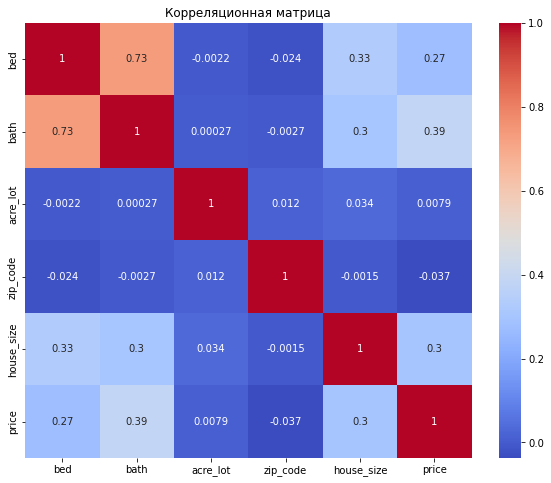

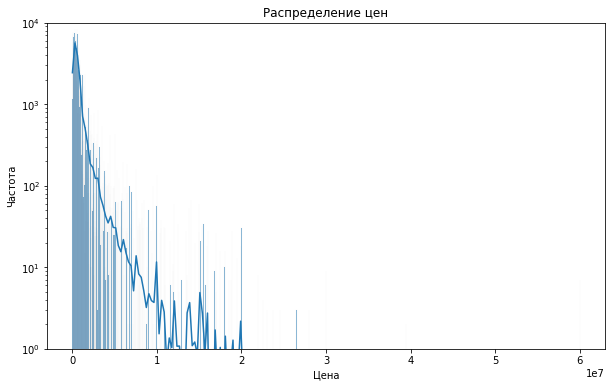

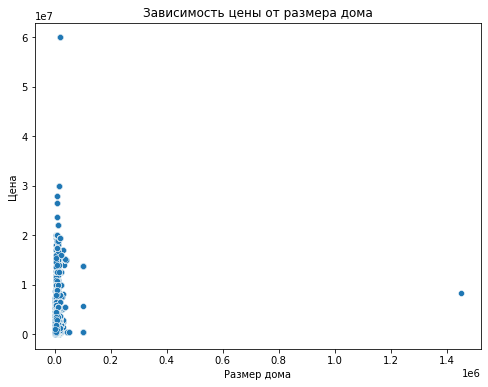

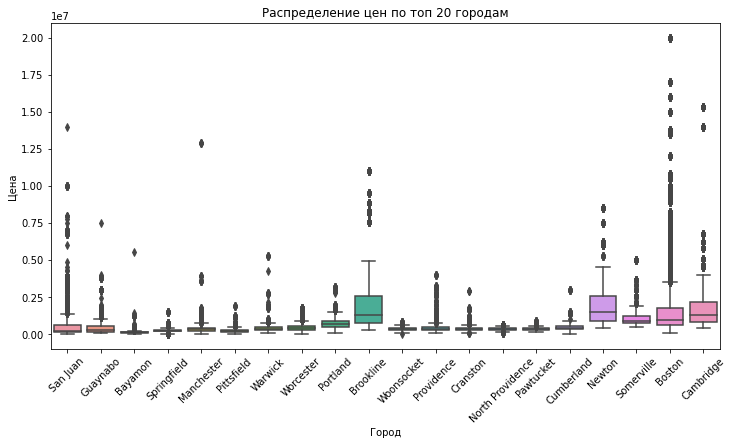

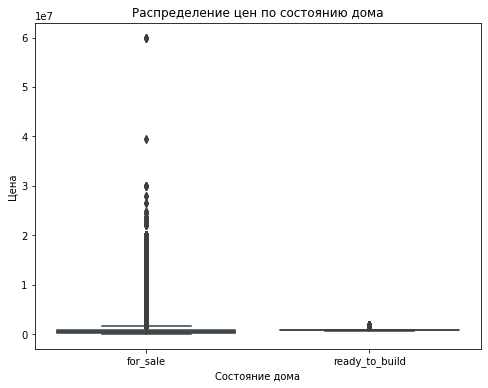

In [60]:
realtor_data.info()
realtor_data.describe()

correlation_matrix = realtor_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=realtor_data, x='price', kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.yscale('log')  # Логарифмическая шкала для оси y
plt.ylim(1, 10000) 
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=realtor_data, x='house_size', y='price')
plt.title('Зависимость цены от размера дома')
plt.xlabel('Размер дома')
plt.ylabel('Цена')
plt.show()

top_20_cities = realtor_data['city'].value_counts().nlargest(20).index
realtor_data_top_cities = realtor_data[realtor_data['city'].isin(top_20_cities)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=realtor_data_top_cities, x='city', y='price')
plt.title('Распределение цен по топ 20 городам')
plt.xlabel('Город')
plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=realtor_data, x='status', y='price')
plt.title('Распределение цен по состоянию дома')
plt.xlabel('Состояние дома')
plt.ylabel('Цена')
plt.show()



Теперь сделаем анализ рынка в разные года и попробуем построить модель, предсказывающую цену в будущем.

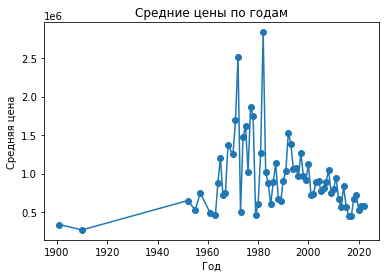

In [61]:
realtor_data['year_sold'] = pd.to_datetime(realtor_data['prev_sold_date']).dt.year
yearly_average_prices = realtor_data.groupby('year_sold')['price'].mean()
yearly_average_prices.plot(marker='o')
plt.title('Средние цены по годам')
plt.xlabel('Год')
plt.ylabel('Средняя цена')
plt.show()

Видим, что цены достаточно волатильны. Попробуем использовать модель линейной регрессии для предсказания цены недвижимости на основе размера дома (площади). Проведем предобработку данных для того, чтобы повысить точность предсказаний модели. Предобработка включает в себя: замена NaN значений средними значениями числовых столбцов и масштабирование данных. Построим модель, а потом применим ее для прогноза цены недвижимости на ближайшие 5 лет.

Средняя абсолютная ошибка (MAE): 0.3902018775077058
Средняя квадратичная ошибка (MSE): 0.8178989279310229


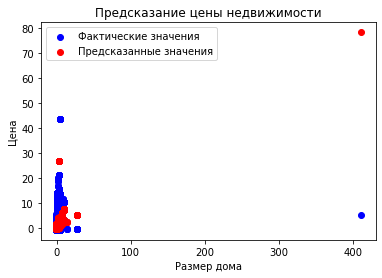

Mean Squared Error (MSE) for the next 5 years: 0.007275869096650552
Mean Absolute Error (MAE) for the next 5 years: 0.08504271209838007


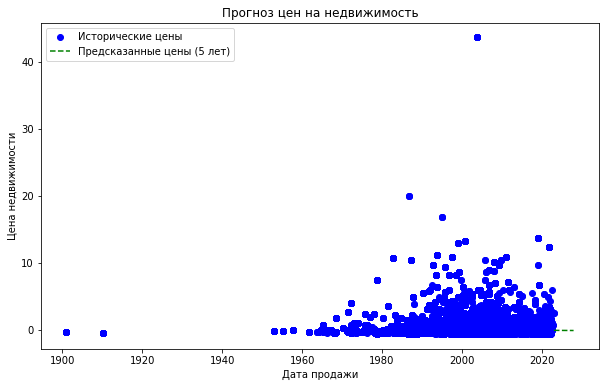

In [62]:
csv_file_path = '/Users/vovidze/Downloads/realtor-data.csv'
realtor_data = pd.read_csv(csv_file_path)

realtor_data = realtor_data.dropna(subset=['bed', 'bath', 'house_size', 'price'])
numeric_columns = realtor_data.select_dtypes(include=np.number).columns
realtor_data[numeric_columns] = realtor_data[numeric_columns].fillna(realtor_data[numeric_columns].mean())
realtor_data['house_size'] = (realtor_data['house_size'] - realtor_data['house_size'].mean()) / realtor_data['house_size'].std()
realtor_data['price'] = (realtor_data['price'] - realtor_data['price'].mean()) / realtor_data['price'].std()

selected_features = ['bed', 'bath', 'house_size']
X = realtor_data[selected_features]
y = realtor_data['price']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)

plt.scatter(X['house_size'], y, color='blue', label='Фактические значения')
plt.scatter(X['house_size'], y_pred, color='red', label='Предсказанные значения')
plt.title('Предсказание цены недвижимости')
plt.xlabel('Размер дома')
plt.ylabel('Цена')
plt.legend()
plt.show()

realtor_data['prev_sold_date'] = pd.to_datetime(realtor_data['prev_sold_date'])

realtor_data = realtor_data.dropna(subset=['prev_sold_date'])

realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['bath'].mean())
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['bed'].mean())
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['house_size'].mean())

realtor_data = realtor_data.replace([np.inf, -np.inf], np.nan)

realtor_data = realtor_data.dropna()

realtor_data['prev_sold_date_ordinal'] = realtor_data['prev_sold_date'].apply(lambda x: x.toordinal())

X_train = realtor_data[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']]
y_train = realtor_data['price']

model = LinearRegression()
model.fit(X_train, y_train)

next_five_years = pd.DataFrame(pd.date_range(start=realtor_data['prev_sold_date'].max(), periods=5*12, freq='M'), columns=['prev_sold_date'])
next_five_years['prev_sold_date_ordinal'] = next_five_years['prev_sold_date'].apply(lambda x: x.toordinal())
next_five_years['bath'] = realtor_data['bath'].mean()  # Среднее количество ванных комнат
next_five_years['bed'] = realtor_data['bed'].mean()  # Среднее количество спален
next_five_years['house_size'] = realtor_data['house_size'].mean()  # Средняя площадь дома

next_five_years['bath'] = next_five_years['bath'].fillna(realtor_data['bath'].mean())
next_five_years['bed'] = next_five_years['bed'].fillna(realtor_data['bed'].mean())
next_five_years['house_size'] = next_five_years['house_size'].fillna(realtor_data['house_size'].mean())

y_pred_next_five_years = model.predict(next_five_years[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']])

y_true_next_five_years = np.repeat(y_train.mean(), len(next_five_years))  # Предположим среднее значение цен в качестве истинного значения
mse_next_five_years = mean_squared_error(y_true_next_five_years, y_pred_next_five_years)
mae_next_five_years = mean_absolute_error(y_true_next_five_years, y_pred_next_five_years)
print("Mean Squared Error (MSE) for the next 5 years:", mse_next_five_years)
print("Mean Absolute Error (MAE) for the next 5 years:", mae_next_five_years)

plt.figure(figsize=(10, 6))
plt.scatter(realtor_data['prev_sold_date'], realtor_data['price'], color='blue', label='Исторические цены')
plt.plot(next_five_years['prev_sold_date'], y_pred_next_five_years, color='green', linestyle='--', label='Предсказанные цены (5 лет)')
plt.xlabel('Дата продажи')
plt.ylabel('Цена недвижимости')
plt.title('Прогноз цен на недвижимость')
plt.legend()
plt.show()

Рассмотрим линию предсказания ближе.

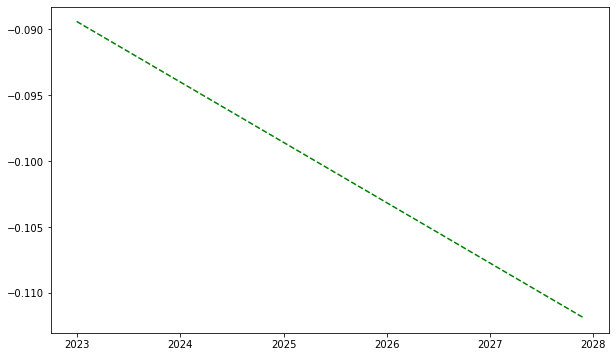

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(next_five_years['prev_sold_date'], y_pred_next_five_years, color='green', linestyle='--', label='Предсказанные цены (5 лет)')
plt.show()

Видим, что есть отрицательные значения цены, что, конечно неверно, это говорит о том, что принцип стандартизации не подходит для предоставленных данных. Попробуем метод нормализации, используя ```MinMaxScaler()``` и сделаем вывод о полученных данных.

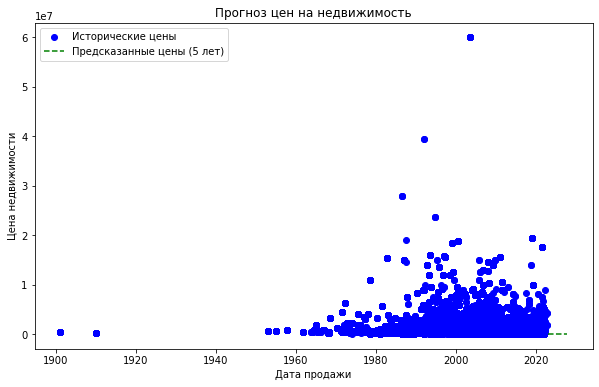

0    1.000674
1    1.001370
2    1.001999
3    1.002695
4    1.003369
Name: prev_sold_date_ordinal, dtype: float64
55    1.038245
56    1.038941
57    1.039615
58    1.040311
59    1.040985
Name: prev_sold_date_ordinal, dtype: float64


In [64]:
csv_file_path = '/Users/vovidze/Downloads/realtor-data.csv'
realtor_data = pd.read_csv(csv_file_path)

realtor_data['prev_sold_date'] = pd.to_datetime(realtor_data['prev_sold_date'])

realtor_data = realtor_data.dropna(subset=['prev_sold_date'])

realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['bath'].mean())
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['bed'].mean())
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['house_size'].mean())
realtor_data['prev_sold_date_ordinal'] = realtor_data['prev_sold_date'].apply(lambda x: x.toordinal())

# Нормализация числовых столбцов
scaler = MinMaxScaler()
realtor_data[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']] = scaler.fit_transform(realtor_data[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']])

X_train = realtor_data[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']]
y_train = realtor_data['price']

model = LinearRegression()
model.fit(X_train, y_train)

next_five_years = pd.DataFrame(pd.date_range(start=realtor_data['prev_sold_date'].max(), periods=5*12, freq='M'), columns=['prev_sold_date'])
next_five_years['prev_sold_date_ordinal'] = next_five_years['prev_sold_date'].apply(lambda x: x.toordinal())
next_five_years['bath'] = realtor_data['bath'].mean()
next_five_years['bed'] = realtor_data['bed'].mean()
next_five_years['house_size'] = realtor_data['house_size'].mean()

# Нормализация данных для следующих 5 лет
next_five_years[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']] = scaler.transform(next_five_years[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']])

y_pred_next_five_years = model.predict(next_five_years[['prev_sold_date_ordinal', 'bath', 'bed', 'house_size']])

y_true_next_five_years = np.repeat(y_train.mean(), len(next_five_years))

plt.figure(figsize=(10, 6))
plt.scatter(realtor_data['prev_sold_date'], realtor_data['price'], color='blue', label='Исторические цены')
plt.plot(next_five_years['prev_sold_date'], next_five_years['prev_sold_date_ordinal'], color='green', linestyle='--', label='Предсказанные цены (5 лет)')
plt.xlabel('Дата продажи')
plt.ylabel('Цена недвижимости')
plt.title('Прогноз цен на недвижимость')
plt.legend()
plt.show()

print(next_five_years["prev_sold_date_ordinal"].head())
print(next_five_years["prev_sold_date_ordinal"].tail())

Видим, что цена будет продолжать расти медленными темпами, поэтому недвижимость может быть интересна инвесторам, избегающим риска и желающим просто заморозить или сохранить свои средства без риска потери или сильного обесценивания.

Исходя из этого поработаем с геоданными и найдем оптимальное жилье для каждого человека со своими критериями.